In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from vae import VAE

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid
import torchvision.transforms as T

from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
!tree lightning_logs

lightning_logs
└── version_0
    ├── checkpoints
    │   └── epoch=286.ckpt
    ├── events.out.tfevents.1598903672.beast.21291.0
    └── hparams.yaml

2 directories, 3 files


In [5]:
vae = VAE.load_from_checkpoint("lightning_logs/version_0/checkpoints/epoch=286.ckpt")
vae.eval();

In [6]:
ds = CIFAR10("data", train=False, transform=T.ToTensor())

In [7]:
num_imgs = 16

In [9]:
imgs = torch.stack([ds[i][0] for i in range(0, num_imgs)])
with torch.no_grad():
    x = vae.encoder(imgs)
    mu = vae.fc_mu(x)
    reconst = vae.decoder(mu)

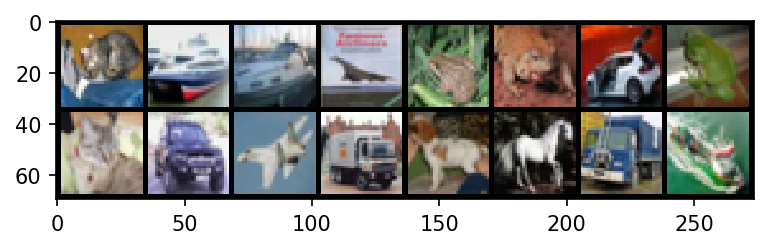

In [22]:
plt.figure(dpi=150)    
plt.imshow(make_grid(imgs).permute(1, 2, 0).numpy())
plt.savefig("figures/input.png")

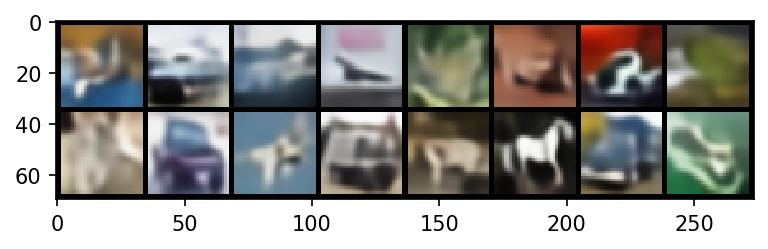

In [23]:
plt.figure(dpi=150)    
plt.imshow(make_grid(reconst).permute(1, 2, 0).numpy())
plt.savefig("figures/reconst.png")

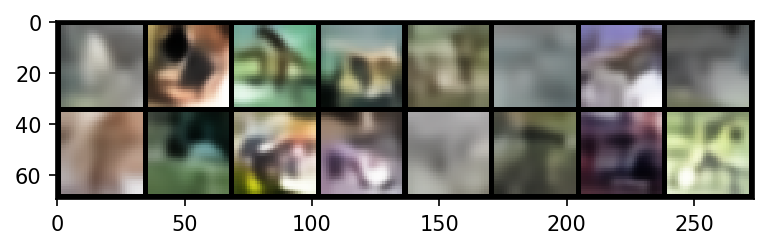

In [25]:
with torch.no_grad():
    z = torch.randn_like(mu)
    gen = vae.decoder(z).squeeze()
plt.figure(dpi=150)    
plt.imshow(make_grid(gen).permute(1, 2, 0).numpy())
plt.savefig("figures/sample.png")

In [26]:
from sklearn.manifold import TSNE

def tsne(model, dataset):
    model.eval()
    dl = DataLoader(dataset, batch_size=512, num_workers=6)
    mus = []
    ys = []
    for x, y in tqdm(dl):
        with torch.no_grad():
            mus.append(model(x)[2])
        ys.append(y)
        
    mu = torch.cat(mus).numpy()
    y = torch.cat(ys).numpy()
    embed = TSNE(n_components=2).fit_transform(mu)
    return embed, y

In [15]:
embed, y = tsne(vae, ds)

  0%|          | 0/20 [00:00<?, ?it/s]/home/teddy/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 20/20 [01:30<00:00,  4.53s/it]


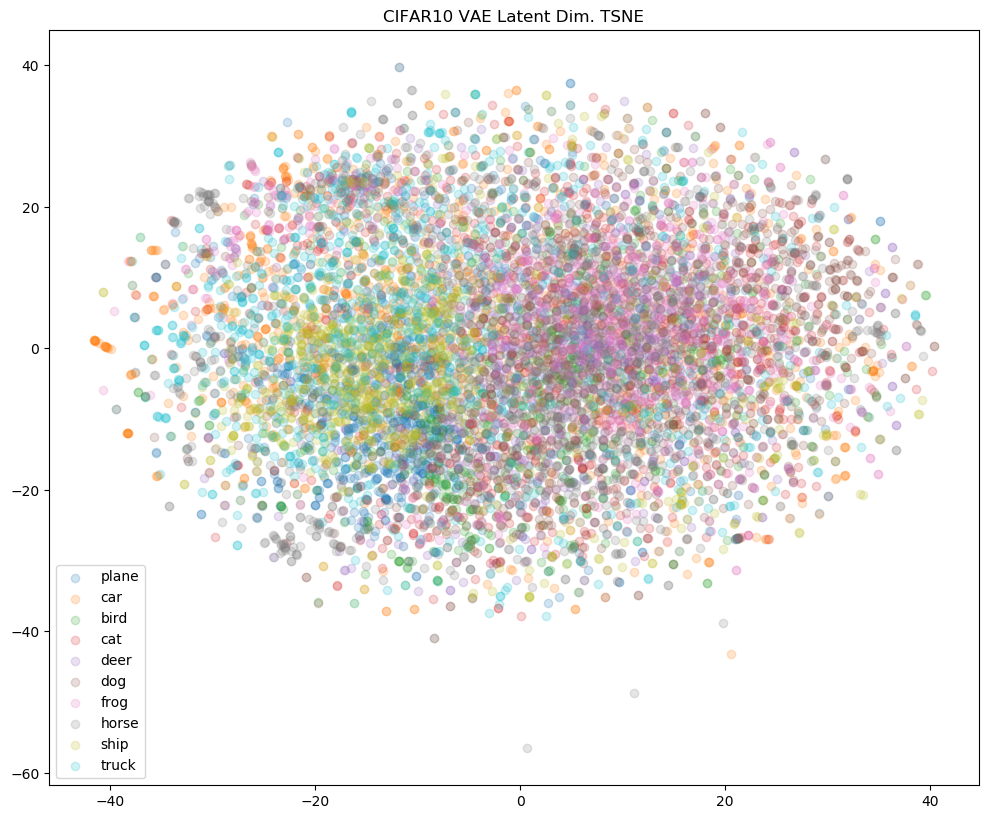

In [27]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(dpi=100, figsize=(12, 10))
for i, c in enumerate(classes):
    idx = y == i
    plt.scatter(embed[idx, 1], embed[idx, 0], alpha=0.2, label=c)
plt.legend()
plt.title("CIFAR10 VAE Latent Dim. TSNE") 
plt.savefig("figures/tsne.png")